Here, I comapre the text part of the additional time embedding.

They should be identical on local/cloud, but are different. 🤔

In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [5]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [6]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [8]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Let's compare text part of additional time embeds

In [9]:
from util import print_shapes
from util_plot import visually_compare_1d

def equal(x,y,atol=1e-4): return allclose(x.cpu(),y.cpu(),atol=atol)

Load cloud additional time embeds

In [10]:
c_vector = torch.load('intermediate_output/temb/cloud/c_vector', map_location='cpu')

emb_c_text,emb_c_orig_sz,emb_c_crop,emb_c_tgt_sz = torch.split(c_vector, [1280, 512, 512, 512], dim=1)

print_shapes(emb_c_text,emb_c_orig_sz,emb_c_crop,emb_c_tgt_sz)

[1, 1280], [1, 512], [1, 512], [1, 512]


Load local additional time embeds

In [11]:
emb_l_time_embeds = torch.load('intermediate_output/temb/local/time_embeds', map_location='cpu')
emb_l_add_embeds = torch.load('intermediate_output/temb/local/add_embeds', map_location='cpu')
emb_l_aug_embeds = torch.load('intermediate_output/temb/local/aug_embeds', map_location='cpu')

emb_l_text_embeds = emb_l_add_embeds[0][:1280]

print_shapes(emb_l_time_embeds, emb_l_add_embeds, emb_l_aug_embeds)

[2, 1536], [2, 2816], [2, 1280]


Let's use shorter names

In [12]:
txt_l = emb_l_text_embeds
txt_c = emb_c_text[0]

In [13]:
assert txt_l.shape==txt_c.shape

In [14]:
equal(txt_c, txt_l)

False

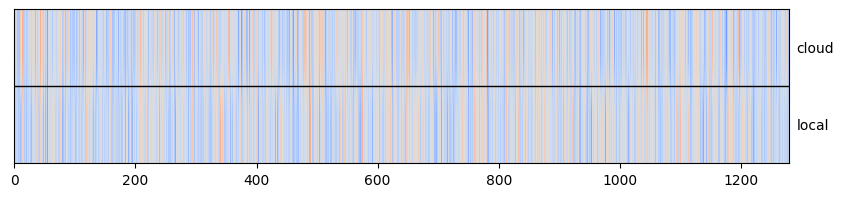

In [15]:
visually_compare_1d((txt_c, txt_l), ('cloud','local'))

In [16]:
txt_c[:10], txt_l[:10]

(tensor([-0.8291,  0.9678, -0.6641,  0.9736, -0.6597, -0.5054, -1.7686, -0.2365, -1.1006, -1.0020]),
 tensor([-0.5941, -0.3394, -0.4070,  0.5561, -1.0181,  0.1388,  0.2324, -1.2147, -0.7827, -0.1039]))

They are different.

___

## Let's re-create the cloud `text_embedder_2` locally 

Maybe I re-create the cloud `text_embedder_2` locally. Then I could compare intermediate results easier.

In [17]:
class AbstractEmbModel(nn.Module):
    def __init__(self):
        super().__init__()
        self._is_trainable = None
        self._ucg_rate = None
        self._input_key = None

    @property
    def is_trainable(self): return self._is_trainable

    @property
    def ucg_rate(self): return self._ucg_rate

    @property
    def input_key(self): return self._input_key

    @is_trainable.setter
    def is_trainable(self, value): self._is_trainable = value

    @ucg_rate.setter
    def ucg_rate(self, value): self._ucg_rate = value

    @input_key.setter
    def input_key(self, value): self._input_key = value

    @is_trainable.deleter
    def is_trainable(self): del self._is_trainable

    @ucg_rate.deleter
    def ucg_rate(self): del self._ucg_rate

    @input_key.deleter
    def input_key(self): del self._input_key

In [18]:
import open_clip

class FrozenOpenCLIPEmbedder2(AbstractEmbModel):
    LAYERS = ["pooled", "last", "penultimate"]

    def __init__(
        self,
        arch="ViT-H-14",
        version="laion2b_s32b_b79k",
        device="cuda",
        max_length=77,
        freeze=True,
        layer="last",
        always_return_pooled=False,
        legacy=True,
    ):
        super().__init__()
        assert layer in self.LAYERS
        model, _, _ = open_clip.create_model_and_transforms(
            arch,
            device=torch.device("cpu"),
            pretrained=version,
        )
        del model.visual
        self.model = model

        self.device = device
        self.max_length = max_length
        self.return_pooled = always_return_pooled
        if freeze:
            self.freeze()
        self.layer = layer
        if self.layer == "last":
            self.layer_idx = 0
        elif self.layer == "penultimate":
            self.layer_idx = 1
        else:
            raise NotImplementedError()
        self.legacy = legacy

    def freeze(self):
        self.model = self.model.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        tokens = open_clip.tokenize(text)
        print('[FrozenOpenCLIPEmbedder2] tokenized inputs:',str(tokens)) 
        z = self.encode_with_transformer(tokens.to(self.device))
        if not self.return_pooled and self.legacy:
            return z
        if self.return_pooled:
            assert not self.legacy
            return z[self.layer], z["pooled"]
        return z[self.layer]

    def encode_with_transformer(self, text):
        x = self.model.token_embedding(text)  # [batch_size, n_ctx, d_model]
        x = x + self.model.positional_embedding
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.text_transformer_forward(x, attn_mask=self.model.attn_mask)
        if self.legacy:
            x = x[self.layer]
            x = self.model.ln_final(x)
            return x
        else:
            # x is a dict and will stay a dict
            o = x["last"]
            o = self.model.ln_final(o)
            pooled = self.pool(o, text)
            x["pooled"] = pooled
            return x

    def pool(self, x, text):
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = (
            x[torch.arange(x.shape[0]), text.argmax(dim=-1)]
            @ self.model.text_projection
        )
        return x

    def text_transformer_forward(self, x: torch.Tensor, attn_mask=None):
        outputs = {}
        for i, r in enumerate(self.model.transformer.resblocks):
            if i == len(self.model.transformer.resblocks) - 1:
                outputs["penultimate"] = x.permute(1, 0, 2)  # LND -> NLD
            if (
                self.model.transformer.grad_checkpointing
                and not torch.jit.is_scripting()
            ):
                x = checkpoint(r, x, attn_mask)
            else:
                x = r(x, attn_mask=attn_mask)
        outputs["last"] = x.permute(1, 0, 2)  # LND -> NLD
        return outputs

    def encode(self, text): return self(text)

In [19]:
text_encoder_2_cfg = {
    'arch': 'ViT-bigG-14',
    'version': 'laion2b_s39b_b160k',
    'freeze': True,
    'layer': 'penultimate',
    'always_return_pooled': True,
    'legacy': False
}

In [20]:
my_txt_enc = FrozenOpenCLIPEmbedder2(**text_encoder_2_cfg)

In [21]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'

In [22]:
tok_len = cnxs_pipe.tokenizer_2.model_max_length
tok_len

77

In [23]:
toks = cnxs_pipe.tokenizer_2(prompt, padding="max_length", max_length=tok_len,truncation=True, return_tensors="pt",).input_ids
toks

tensor([[49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [24]:
recreated_txt_c = my_txt_enc.encode_with_transformer(toks)
print(recreated_txt_c.keys())
recreated_txt_c = recreated_txt_c['pooled'][0] # [0] to remove unit axis
recreated_txt_c.shape

dict_keys(['penultimate', 'last', 'pooled'])


torch.Size([1280])

In [25]:
assert txt_c.shape==recreated_txt_c.shape

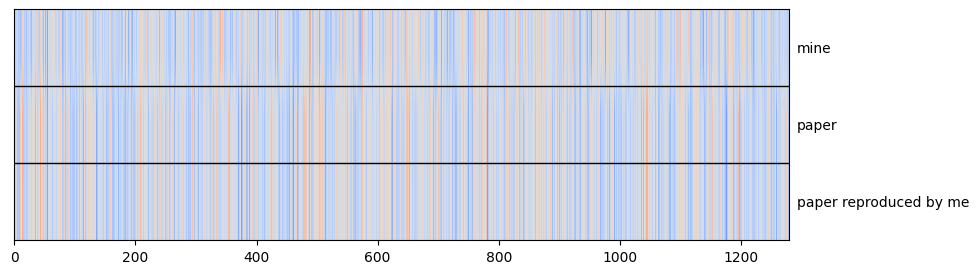

In [26]:
visually_compare_1d(
    [txt_l, txt_c, recreated_txt_c],
    ('mine', 'paper', 'paper reproduced by me'),
    joint=True
)

In [27]:
txt_c[:10], recreated_txt_c[:10] 

(tensor([-0.8291,  0.9678, -0.6641,  0.9736, -0.6597, -0.5054, -1.7686, -0.2365, -1.1006, -1.0020]),
 tensor([-0.8294,  0.9691, -0.6637,  0.9749, -0.6590, -0.5058, -1.7676, -0.2369, -1.1004, -1.0016]))

In [28]:
equal(txt_c, recreated_txt_c, atol=1e-3)

False

In [29]:
equal(txt_c, recreated_txt_c, atol=1e-2)

True

Okay, I can recreate the cloud text embeds (up to 1e2, which I consider operational randomess)

In [30]:
embedder_c = my_txt_enc
embedder_l = cnxs_pipe.text_encoder_2

In [31]:
type(embedder_c), type(embedder_l)

(__main__.FrozenOpenCLIPEmbedder2,
 transformers.models.clip.modeling_clip.CLIPTextModelWithProjection)

In [32]:
embedder_l

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 1280)
      (position_embedding): Embedding(77, 1280)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (layer_norm2): La

In [33]:
embedder_c

FrozenOpenCLIPEmbedder2(
  (model): CLIP(
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-31): 32 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (token_embedding): Embedding(49408, 1280)
    (ln_final): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
)

In [34]:
assert embedder_l.text_model.embeddings.position_embedding.weight.shape == embedder_c.model.positional_embedding.shape

In [35]:
equal(embedder_l.text_model.embeddings.position_embedding.weight, embedder_c.model.positional_embedding, atol=1e-3)

True

Let's manually step through the CLIP forward

Edit: I didn't even need to to that, as I learned the recreated txt_l is different from the saved txt_l

In [36]:
class MyLocalCLIP:
    tok_emb = embedder_l.text_model.embeddings.token_embedding
    pos_emb = embedder_l.text_model.embeddings.position_embedding
    resblocks = embedder_l.text_model.encoder.layers
    layer_norm_final = embedder_l.text_model.final_layer_norm
    text_proj = embedder_l.text_projection

In [37]:
class MyCloudCLIP:
    tok_emb = embedder_c.model.token_embedding
    pos_emb = embedder_c.model.positional_embedding
    resblocks = embedder_c.model.transformer.resblocks
    layer_norm_final = embedder_c.model.ln_final
    text_proj = embedder_c.model.text_projection

    def __call__(self,text):
        x = tok_emb(text)  # [batch_size, n_ctx, d_model]
        x = x + pos_emb
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.text_transformer_forward(x, attn_mask=self.model.attn_mask)
        # x is a dict and will stay a dict
        o = x["last"]
        o = self.model.ln_final(o)
        pooled = self.pool(o, text)
        x["pooled"] = pooled
        return x

Let's recreate the `txt_l`

In [38]:
txt_output_l = embedder_l.text_model(toks.to(device))
pooled_output_l = txt_output_l.pooler_output
txt_embs_l = embedder_l.text_projection(pooled_output_l)

In [39]:
txt_embs_l = txt_embs_l.cpu().detach()[0]

In [40]:
pooled_output_l.shape, txt_embs_l.shape

(torch.Size([1, 1280]), torch.Size([1280]))

In [41]:
equal(txt_embs_l, txt_l)

False

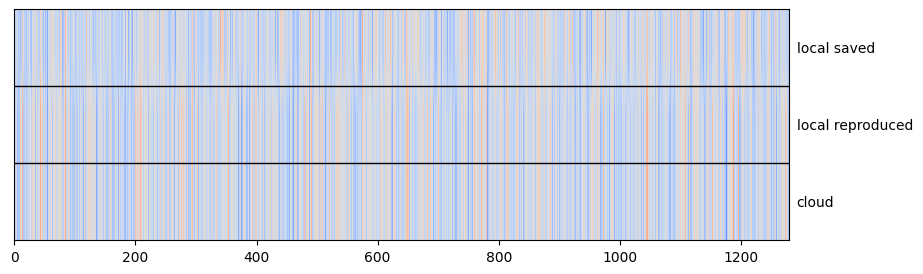

In [42]:
visually_compare_1d(
    (txt_l, txt_embs_l, txt_c),
    ('local saved', 'local reproduced', 'cloud'),
)

In [43]:
equal(txt_embs_l, txt_c, atol=1e-2)

True

**Manually creating the text embs with the local model creates the same outputs as the cloud model!**

Did I save the wrong local text emb tensor?

In [44]:
_,_,txt_l_manual_from_pipe,_ = cnxs_pipe.encode_prompt(prompt)
txt_l_manual_from_pipe = txt_l_manual_from_pipe.cpu().detach()[0]

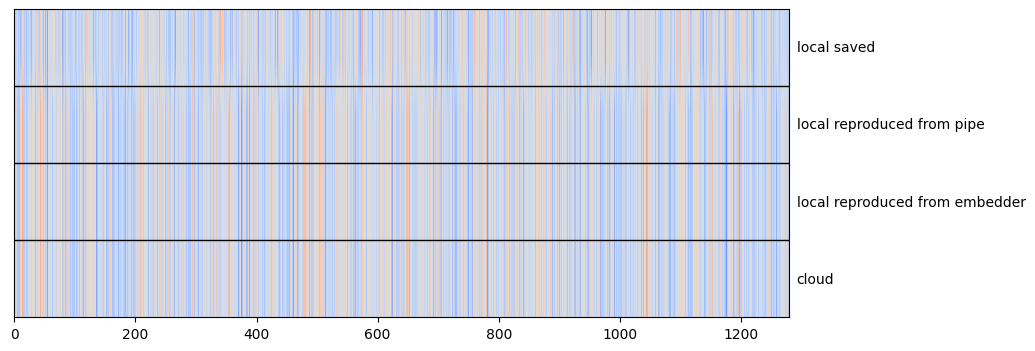

In [45]:
visually_compare_1d(
    (txt_l, txt_l_manual_from_pipe, txt_embs_l, txt_c),
    ('local saved', 'local reproduced from pipe', 'local reproduced from embedder', 'cloud'),
)

In [46]:
equal(txt_l_manual_from_pipe, txt_c, atol=1e-2)

True

In [47]:
txt_l[:10], txt_l_manual_from_pipe[:10], txt_embs_l[:10], txt_c[:10]

(tensor([-0.5941, -0.3394, -0.4070,  0.5561, -1.0181,  0.1388,  0.2324, -1.2147, -0.7827, -0.1039]),
 tensor([-0.8297,  0.9690, -0.6633,  0.9744, -0.6591, -0.5058, -1.7675, -0.2365, -1.1004, -1.0020]),
 tensor([-0.8297,  0.9690, -0.6633,  0.9744, -0.6591, -0.5058, -1.7675, -0.2365, -1.1004, -1.0020]),
 tensor([-0.8291,  0.9678, -0.6641,  0.9736, -0.6597, -0.5054, -1.7686, -0.2365, -1.1006, -1.0020]))

**I was using the wrong dimension!**<br/>
The prompt is in dim 1, not dim 0. Dim 0 contains the negative prompt.

In [55]:
txt_l_dim1 = emb_l_add_embeds[1][:1280]

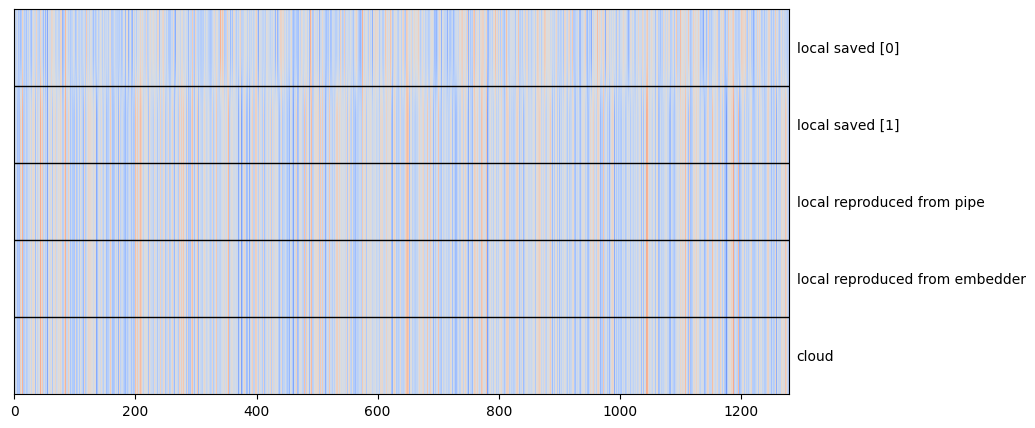

In [56]:
visually_compare_1d(
    (txt_l, txt_l_dim1, txt_l_manual_from_pipe, txt_embs_l, txt_c),
    ('local saved [0]', 'local saved [1]', 'local reproduced from pipe', 'local reproduced from embedder', 'cloud'),
)

___

**Next:** Understand the dimensions of cond,uncond,empty text information.

My expectation: We have 3 text emb vectors, one each of:
- prompt
- negative prompt
- empty prompt

Is dim 0 of `txt_l` maybe equal to the cloud `uc_vector`? (I don't expect it to be.)

In [79]:
uc_vector = torch.load('intermediate_output/temb/cloud/uc_vector', map_location='cpu')
emb_c_text_uc,_,_,_ = torch.split(uc_vector, [1280, 512, 512, 512], dim=1)

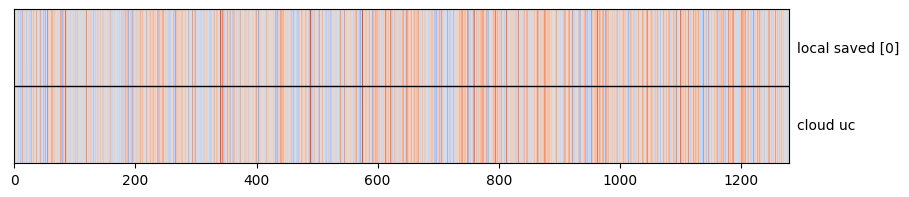

In [80]:
visually_compare_1d(
    (txt_l, emb_c_text_uc),
    ('local saved [0]', 'cloud uc'),
)

Nope. But good try.
**Edit: Yes**, they're equal. I had wrongly loaded the `c_vector` instead of `uc_vector`

___

Here's the diffusers code for classifier-free guidance:

```
if do_classifier_free_guidance:
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
```

So (for `num_images_per_prompt=1`, the batch dimension is 2. For `prompt` and `empty`.

**Q:** Where is the negative prompt handled?

**A: The negative and uncondtional prompts are the same concept!**

In `encode_prompt`: `negative_prompt = negative_prompt or ""`

In `__call__`:
```
encode_prompt(...)

...

if do_classifier_free_guidance:
    prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
    add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)
```

___

But then `txt_l[0]` and cloud `uc_vector` **should** be equal!

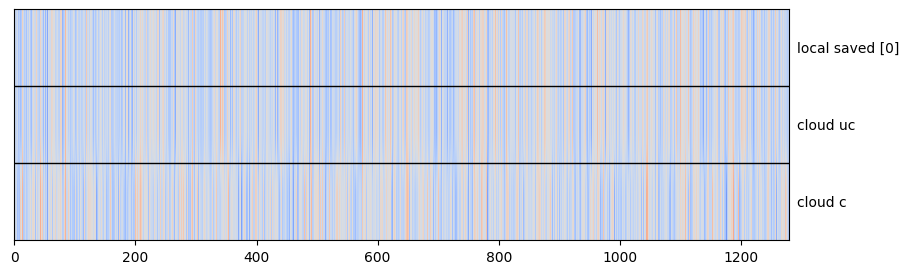

In [81]:
visually_compare_1d(
    (txt_l, emb_c_text_uc, emb_c_text),
    ('local saved [0]', 'cloud uc', 'cloud c'),
)

In [88]:
equal(txt_l,emb_c_text_uc,atol=1e-2)

True

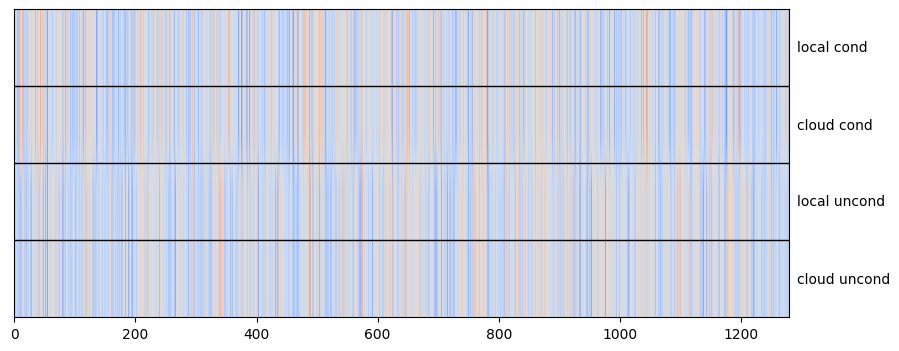

In [90]:
visually_compare_1d(
    (txt_l_dim1, emb_c_text, txt_l, emb_c_text_uc),
    ('local cond', 'cloud cond', 'local uncond', 'cloud uncond'),
)

___

In conclusion, the text part of the additional time embedding **is** identical on local/cloud.